In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import math

from itertools import product
from collections import Counter
import math
import sys

Загрузим данные и сделаем оверсэмплинг, как в прошлой работе

In [13]:
df_iris = pd.read_csv('iris.csv')
df_adm = pd.read_csv('admission.csv')

In [14]:
X = df_iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df_iris['species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

sampling_strategy_dict = {0: 200, 1: 200, 2: 200}

smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42, k_neighbors=10)
X_resampled, y_resampled_encoded = smote.fit_resample(X, y_encoded)

y_resampled = le.inverse_transform(y_resampled_encoded)

df_iris_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_iris_resampled['species'] = y_resampled

print("\nРаспределение классов после оверсэмплинга:\n", df_iris_resampled['species'].value_counts())
print("\nНовый размер датасета:", df_iris_resampled.shape)


Распределение классов после оверсэмплинга:
 species
Iris-setosa        200
Iris-versicolor    200
Iris-virginica     200
Name: count, dtype: int64

Новый размер датасета: (600, 5)


**КЛАССИФИКАЦИЯ**

**Бейзлайн**

Обучим бейзлайн классификации. Разделим выборку на тренировочную и тестовую и обучим классификатор на основе случайного леса.

In [15]:
X_cls = df_iris_resampled.drop('species', axis=1)
y_cls = df_iris_resampled['species']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

rf_cls_base = RandomForestClassifier(random_state=42)
rf_cls_base.fit(X_train_cls, y_train_cls)

y_pred_cls = rf_cls_base.predict(X_test_cls)
acc_base = accuracy_score(y_test_cls, y_pred_cls)
print(f"Baseline Classification Accuracy: {acc_base:.4f}")

Baseline Classification Accuracy: 0.9583


В результате получили хорошую точность классификации, практически идеальная метрика

Посмотрим, какие классы путаются друг с другом классификатором

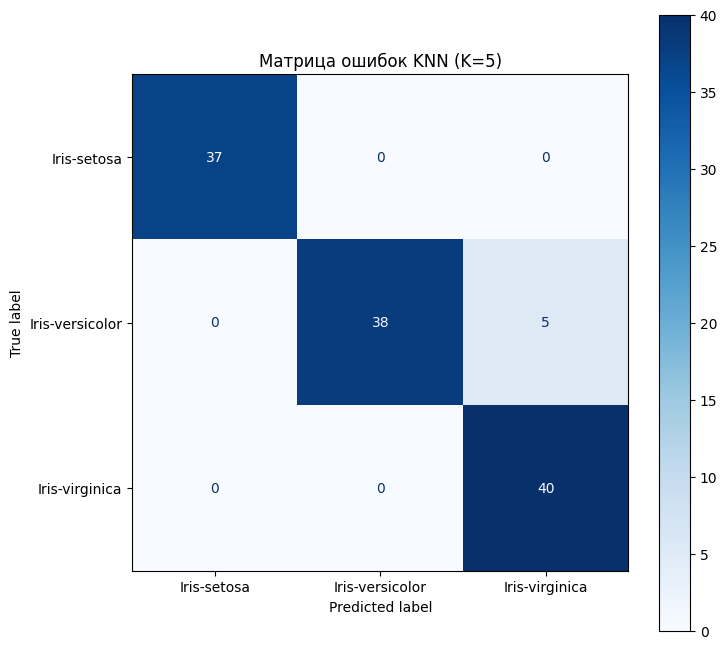

In [16]:
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls_base.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Матрица ошибок KNN (K=5)")
plt.show()

In [17]:
rf_cls_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

**Улучшения**

Попытаемся подобрать гиперпараметры по сетке. Особенность случайного леса в том, что этот алгоритм не имеет свойства переобучаться, потому что он усредняет показания нескольких деревьев, даже глубоких и переобученных. К тому же переобучать отдельные эстиматоры даже полезно, потому что они учатся на разных подвыборках данных и поэтому переобучаются по-разному.

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5]
}


grid_cls = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1)

grid_cls.fit(X_train_cls, y_train_cls)
best_rf_cls = grid_cls.best_estimator_

Посмотрим, какие мы получили параметры лучшего леса

In [19]:
best_rf_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:

y_pred_cls_tuned = best_rf_cls.predict(X_test_cls)
acc_tuned = accuracy_score(y_test_cls, y_pred_cls_tuned)

print(f"Tuned Classification Accuracy: {acc_tuned:.4f}")
print(f"Improvement: {acc_tuned - acc_base:.4f}")

Tuned Classification Accuracy: 0.9583
Improvement: 0.0000


**Результат:** Мы видим, что результат не улучшился, более того дефолтная модель имеет те же самые гиперпараметры, что и улучшенная. Мне кажется, что причина этому все в той же простоте датасета. Какие-то  Часть данных разделима очень хорошо, другая часть разделяется плохо, что решается древесными нелинейными алгоритмами, а вот определенная часть не разделяется совсем, поэтому мы не получаем идеальный результат на классификации никогда. 

**РЕГРЕССИЯ**

**Бейзлайн**

Обучим бейзлайн, предварительно убрав колонку серийного номера

In [21]:
X_reg = df_adm.drop(['Chance of Admit ', 'Serial No.'], axis=1)
y_reg = df_adm['Chance of Admit ']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

rf_reg_base = RandomForestRegressor(random_state=42)
rf_reg_base.fit(X_train_reg, y_train_reg)

y_pred_reg = rf_reg_base.predict(X_test_reg)

r2_base = r2_score(y_test_reg, y_pred_reg)
mae_base = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Baseline Regression R2: {r2_base:.4f}")
print(f"Baseline Regression MAE: {mae_base:.4f}")

Baseline Regression R2: 0.8066
Baseline Regression MAE: 0.0498


Получили хороший результат уже из коробки. Попробуем подобрать гиперпараметры на сетке с помощью кросс-валидации

**Улучшения**

Попробуем улучшить точность регрессии, подобрав гиперпараметры на сетке с кросс-валидацией

In [22]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5]
}

grid_reg = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                        param_grid=param_grid,
                        cv=5,
                        scoring='r2',
                        n_jobs=-1)

grid_reg.fit(X_train_reg, y_train_reg) 
best_rf_reg = grid_reg.best_estimator_

In [23]:
y_pred_reg_tuned = best_rf_reg.predict(X_test_reg)
r2_tuned = r2_score(y_test_reg, y_pred_reg_tuned)
mae_tuned = mean_absolute_error(y_test_reg, y_pred_reg_tuned)

print(f"Best Regression R2: {r2_tuned:.4f}")
print(f"Best Regression MAE: {mae_tuned:.4f}")

Best Regression R2: 0.8179
Best Regression MAE: 0.0473


**ИМПЛЕМЕНТАЦИЯ**

Переиспользуем некоторые уже написанные функции из прошлой лабораторной работы

In [38]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_mean)**2)
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)

def train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

def custom_k_fold_split(X, y, n_splits=5, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield (train_indices, test_indices)
        current = stop

def custom_grid_search(X_train, y_train, model_class, param_grid,
                       n_splits=5, scoring='r2'):
    
    maximize_metrics = {'accuracy', 'r2', 'f1'}
    minimize_metrics = {'mae', 'mse'}
    
    if scoring in maximize_metrics:
        compare = lambda new, best: new > best
        best_score = -np.inf
    elif scoring in minimize_metrics:
        compare = lambda new, best: new < best
        best_score = np.inf
    else:
        raise ValueError(f"Метрика '{scoring}' не поддерживается")

    best_params = None

    keys, values = zip(*param_grid.items())
    
    for params in product(*values):
        param_dict = dict(zip(keys, params))
        fold_scores = []

        for tr_idx, val_idx in custom_k_fold_split(X_train, y_train, n_splits=n_splits):
            X_tr = X_train.iloc[tr_idx]
            X_val = X_train.iloc[val_idx]
            
            y_tr = y_train.iloc[tr_idx]
            y_val = y_train.iloc[val_idx]

            model = model_class(**param_dict)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)

            if scoring == 'r2':
                score = calculate_r2(y_val.values, pred)
            elif scoring == 'mae':
                score = calculate_mae(y_val.values, pred)
            elif scoring == 'accuracy':
                score = np.mean(y_val.values == pred)
            else:
                raise ValueError(f"Метрика '{scoring}' не поддерживается")

            fold_scores.append(score)

        mean_score = np.mean(fold_scores)

        print(f"{param_dict} -> {scoring}={mean_score:.4f}")

        if compare(mean_score, best_score):
            best_score = mean_score
            best_params = param_dict

    return best_params, best_score

**Классификация**

Имплементируем класс Случайный Лес. Для этого возьмем уже ранеее имплементированное дерево решений. Ведь случайный лес строит несколько деревьев на разных подвыборках данных, а затем усредняет их предсказания, тем самым компенсируя шумные переобученные деревья. 

In [39]:
class TreeNode:
    def __init__(self, *, feature_idx=None, threshold=None, left=None, right=None, value=None, is_leaf=False):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf

class DecisionTree:
    def __init__(self, task='classification', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None, max_features=None):
        assert task in ('classification', 'regression')
        self.task = task
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.root = None
        self.random_state = random_state
        self._rng = np.random.RandomState(random_state)
        self.max_features = max_features 

    def _gini(self, y):
        if len(y) == 0:
            return 0
        vals, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs**2)

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features is None:
            feature_indices = range(n_features)
        else:
            k = self.max_features
            k = max(1, min(n_features, int(k)))
            feature_indices = self._rng.choice(n_features, k, replace=False)
        best_feat, best_thresh, best_gain = None, None, -np.inf
        current_impurity = self._gini(y) if self.task == 'classification' else self._mse(y)

        for feat in feature_indices:
            col = X[:, feat]
            unique_values = np.unique(col)
            if unique_values.shape[0] == 1:
                continue
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
            for thresh in thresholds:
                left_mask = col <= thresh
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue
                if self.task == 'classification':
                    left_imp = self._gini(y[left_mask])
                    right_imp = self._gini(y[right_mask])
                    n_left = left_mask.sum()
                    n_right = right_mask.sum()
                    weighted_impurity = (n_left * left_imp + n_right * right_imp) / (n_left + n_right)
                    gain = current_impurity - weighted_impurity
                else:
                    left_imp = self._mse(y[left_mask])
                    right_imp = self._mse(y[right_mask])
                    n_left = left_mask.sum()
                    n_right = right_mask.sum()
                    weighted_impurity = (n_left * left_imp + n_right * right_imp) / (n_left + n_right)
                    gain = current_impurity - weighted_impurity

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = thresh

        return best_feat, best_thresh, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]

        if n_samples == 0:
            return TreeNode(is_leaf=True, value=None)
        if self.max_depth is not None and depth >= self.max_depth:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))
        if n_samples < self.min_samples_split:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))
        if self.task == 'classification':
            if len(np.unique(y)) == 1:
                return TreeNode(is_leaf=True, value=self._leaf_value(y))
        else:
            if np.allclose(y, y[0]):
                return TreeNode(is_leaf=True, value=self._leaf_value(y))

        feat, thresh, gain = self._best_split(X, y)
        if feat is None or gain <= 0:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))

        left_mask = X[:, feat] <= thresh
        right_mask = ~left_mask

        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return TreeNode(feature_idx=feat, threshold=thresh, left=left_node, right=right_node, is_leaf=False)

    def _leaf_value(self, y):
        if len(y) == 0:
            return None
        if self.task == 'classification':
            most_common = Counter(y).most_common(1)[0][0]
            return most_common
        else:
            return np.mean(y)

    def fit(self, X_df, y_sr):
        X = X_df.values.astype(float)
        y = y_sr.values
        n_features = X.shape[1]
        if self.max_features is None:
            if self.task == 'classification':
                self.max_features = max(1, int(math.sqrt(n_features)))
            else:
                self.max_features = n_features
        self.root = self._build_tree(X, y, depth=0)

    def _predict_one(self, x, node):
        if node.is_leaf:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X_df):
        X = X_df.values.astype(float)
        preds = np.array([self._predict_one(x, self.root) for x in X])
        return preds

Здесь создадим класс Случайный лес, от которого унаследуется классификатор и регрессор на основе случайного леса. 

In [48]:
class RandomForestBase:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = int(n_estimators)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.random_state = random_state
        self.trees = []
        self._rng = np.random.RandomState(random_state)

    def _bootstrap_sample(self, X_df, y_sr):
        n = X_df.shape[0]
        indices = self._rng.randint(0, n, size=n) 
        return X_df.iloc[indices].reset_index(drop=True), y_sr.iloc[indices].reset_index(drop=True)

class RandomForestClassifier(RandomForestBase):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        super().__init__(n_estimators, max_depth, min_samples_split, min_samples_leaf, random_state)

    def fit(self, X_df, y_sr):
        self.trees = []
        for i in range(self.n_estimators):
            X_samp, y_samp = self._bootstrap_sample(X_df, y_sr)
            tree = DecisionTree(task='classification', max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf,
                                random_state=self._rng.randint(0, 1e9))
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X_df):
        preds = np.vstack([tree.predict(X_df) for tree in self.trees])
        n_samples = preds.shape[1]
        final = []
        for j in range(n_samples):
            col = preds[:, j]
            counter = Counter(col)
            most_common = counter.most_common()
            most_common.sort(key=lambda x: (-x[1], x[0])) 
            final.append(most_common[0][0])
        return np.array(final)

class RandomForestRegressor(RandomForestBase):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        super().__init__(n_estimators, max_depth, min_samples_split, min_samples_leaf, random_state)

    def fit(self, X_df, y_sr):
        self.trees = []
        for i in range(self.n_estimators):
            X_samp, y_samp = self._bootstrap_sample(X_df, y_sr)
            tree = DecisionTree(task='regression', max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf,
                                random_state=self._rng.randint(0, 1e9))
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X_df):
        preds = np.vstack([tree.predict(X_df).astype(float) for tree in self.trees])  # (n_trees, n_samples)
        avg = np.mean(preds, axis=0)
        return avg

**Бейзлайн**

Обучим классификатор на дефолтных гиперпараметрах, как в библиотечной реализации

In [50]:
X_cls = df_iris_resampled.drop('species', axis=1)
y_cls = df_iris_resampled['species']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

In [42]:
rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf.fit(X_train_cls.reset_index(drop=True), y_train_cls.reset_index(drop=True))
pred = rf.predict(X_test_cls.reset_index(drop=True))
acc = calculate_accuracy(y_test_cls.values, pred)
print(f"Baseline RF accuracy = {acc:.4f}")

Baseline RF accuracy = 0.9583


Результат мы получили в точности такой же, как и в библиотечной реализации. Это хорошая метрика, но и про то, что наш датасет достаточно простой, тоже не надо забывать

**Улучшения**

In [46]:
param_grid = {
        'n_estimators': [5, 10, 20],
        'max_depth': [None, 3, 5],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2]
    }

best_params, best_score = custom_grid_search(X_train_cls.reset_index(drop=True), y_train_cls.reset_index(drop=True),
                                             RandomForestClassifier, param_grid,
                                             n_splits=5, scoring='accuracy')
print("Best params:", best_params, "Best CV accuracy:", best_score)



{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1} -> accuracy=0.9917
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2} -> accuracy=0.9896
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1} -> accuracy=0.9938
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2} -> accuracy=0.9938
{'n_estimators': 5, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1} -> accuracy=0.9812
{'n_estimators': 5, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} -> accuracy=0.9812
{'n_estimators': 5, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1} -> accuracy=0.9771
{'n_estimators': 5, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2} -> accuracy=0.9833
{'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1} -> accuracy=0.9917
{'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 2, 'min_sampl

In [51]:
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_cls.reset_index(drop=True), y_train_cls.reset_index(drop=True))
pred_best = best_rf.predict(X_test_cls.reset_index(drop=True))
acc_best = calculate_accuracy(y_test_cls.values, pred_best)
print(f"RF accuracy with best params = {acc_best:.4f}")

RF accuracy with best params = 0.9722


В результате мы улучшили метрику из бейзлайна. Более того, мы получили метрику даже немногим лучше, чем метрика библиотечного классификатора, гиперпараметры которого нашли по сетке. Хотелось бы отметить, что изменился гиперпараметр, отвечающий за количество деревьев в лесу, т.е как раз ради чего строится лес - усреднение шума в отдельных переобученных эстиматорах.

**Регрессия**

In [55]:
class RandomForestRegressor(RandomForestBase):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        super().__init__(n_estimators, max_depth, min_samples_split, min_samples_leaf, random_state)

    def fit(self, X_df, y_sr):
        self.trees = []
        for i in range(self.n_estimators):
            X_samp, y_samp = self._bootstrap_sample(X_df, y_sr)
            tree = DecisionTree(task='regression', max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf,
                                random_state=self._rng.randint(0, 1e9))
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X_df):
        preds = np.vstack([tree.predict(X_df).astype(float) for tree in self.trees])
        avg = np.mean(preds, axis=0)
        return avg

**Бейзлайн**

In [56]:
X_reg = df_adm.drop(['Chance of Admit ', 'Serial No.'], axis=1)
y_reg = df_adm['Chance of Admit ']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [58]:
rf_reg = RandomForestRegressor(n_estimators=10, max_depth=6, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_reg.fit(X_train_reg.reset_index(drop=True), y_train_reg.reset_index(drop=True))
pred = rf_reg.predict(X_test_reg.reset_index(drop=True))
r2 = calculate_r2(y_test_reg.values, pred)
mae = calculate_mae(y_test_reg.values, pred)
print(f"Baseline RF regressor: R2={r2:.4f}, MAE={mae:.4f}")

Baseline RF regressor: R2=0.7877, MAE=0.0496


В результате мы получили хорошие метрики, хоть и чуть хуже, чем в библиотечном бейзлайне. Попробуем найти оптимальные гиперпараметры на кросс-валидации

**Улучшения**

Попробуем найти оптимальные гиперпараметры на сетке с кросс-валидацией, чтобы улучшить метрики

In [60]:
param_grid = {
        'n_estimators': [5, 10, 20],
        'max_depth': [None, 4, 6],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2]
    }

In [61]:
best_params, best_score = custom_grid_search(X_train_reg.reset_index(drop=True), y_train_reg.reset_index(drop=True),
                                                 RandomForestRegressor, param_grid,
                                                 n_splits=5, scoring='r2')
print("Best params:", best_params, "Best CV r2:", best_score)

{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1} -> r2=0.6808
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2} -> r2=0.7042
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1} -> r2=0.6922
{'n_estimators': 5, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2} -> r2=0.6687
{'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1} -> r2=0.7134
{'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2} -> r2=0.7229
{'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1} -> r2=0.7320
{'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2} -> r2=0.7257
{'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1} -> r2=0.7045
{'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2} -> r2=0.6971
{'n_estimators': 5, 'max_dep

Полученные гиперпараметры сильно отличаются от тех, что были выставлены при обучении бейзлайна.

In [63]:
best_rf_reg = RandomForestRegressor(**best_params, random_state=42)
best_rf_reg.fit(X_train_reg.reset_index(drop=True), y_train_reg.reset_index(drop=True))
pred_best = best_rf_reg.predict(X_test_reg.reset_index(drop=True))
r2_best = calculate_r2(y_test_reg.values, pred_best)
mae_best = calculate_mae(y_test_reg.values, pred_best)
print(f"RF regressor with best params: R2={r2_best:.4f}, MAE={mae_best:.4f}")

RF regressor with best params: R2=0.8007, MAE=0.0483


В результате мы получили хорошие метрики имплементированной версии после улучшения. Эти метрики лучше, чем у базовой версии, но немного хуже, чем у библиотечной. В библиотечной реализации классификатора с подбором гиперпараметров была получена метрика R2 около 0.81, у нас же 0.8. Разница несущественная, я думаю, что эта разница варьируется от рандом стейта и подвыборки